In [1]:
import pandas as pd
import kagglehub
import os
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from tabulate import tabulate

In [2]:
import kagglehub
# Download latest version
path = kagglehub.dataset_download("ravikumargattu/network-traffic-dataset")

# Cek file yang ada pada folder
print("Path to dataset files:", path)
print(os.listdir(path))
file_path = os.path.join(path, "Midterm_53_group.csv")

Using Colab cache for faster access to the 'network-traffic-dataset' dataset.
Path to dataset files: /kaggle/input/network-traffic-dataset
['Midterm_53_group.csv', 'output1.csv']


In [3]:
# Load salah satu csv
df = pd.read_csv(file_path)
print(tabulate(df.head(5), headers='keys', tablefmt='fancy_grid'))

╒════╤══════════╤═════════════════╤═══════╤═════════════════╤════════════╤══════════╤═════════════════════════════════════════╕
│    │     Time │ Source          │   No. │ Destination     │ Protocol   │   Length │ Info                                    │
╞════╪══════════╪═════════════════╪═══════╪═════════════════╪════════════╪══════════╪═════════════════════════════════════════╡
│  0 │ 0        │ 192.167.8.166   │     1 │ 192.167.255.255 │ NBNS       │       92 │ Name query NB WPAD<00>                  │
├────┼──────────┼─────────────────┼───────┼─────────────────┼────────────┼──────────┼─────────────────────────────────────────┤
│  1 │ 0.784682 │ 192.167.8.166   │     2 │ 192.167.255.255 │ NBNS       │       92 │ Name query NB WPAD<00>                  │
├────┼──────────┼─────────────────┼───────┼─────────────────┼────────────┼──────────┼─────────────────────────────────────────┤
│  2 │ 1.16906  │ VMware_8a:5c:e6 │     3 │ Broadcast       │ ARP        │       60 │ Who has 192.167.7.

In [4]:
# cek tipe data
datatype = df.dtypes.reset_index()
datatype.columns = ['column_name', 'column_type']
print(tabulate(datatype, headers='keys', tablefmt='fancy_grid'))

╒════╤═══════════════╤═══════════════╕
│    │ column_name   │ column_type   │
╞════╪═══════════════╪═══════════════╡
│  0 │ Time          │ float64       │
├────┼───────────────┼───────────────┤
│  1 │ Source        │ object        │
├────┼───────────────┼───────────────┤
│  2 │ No.           │ int64         │
├────┼───────────────┼───────────────┤
│  3 │ Destination   │ object        │
├────┼───────────────┼───────────────┤
│  4 │ Protocol      │ object        │
├────┼───────────────┼───────────────┤
│  5 │ Length        │ int64         │
├────┼───────────────┼───────────────┤
│  6 │ Info          │ object        │
╘════╧═══════════════╧═══════════════╛


In [5]:
# cek missing data
missing = df.isnull().sum().reset_index()
missing.columns = ['column_name', 'missing_count']
print(tabulate(missing, headers='keys', tablefmt='fancy_grid'))

╒════╤═══════════════╤═════════════════╕
│    │ column_name   │   missing_count │
╞════╪═══════════════╪═════════════════╡
│  0 │ Time          │               0 │
├────┼───────────────┼─────────────────┤
│  1 │ Source        │               0 │
├────┼───────────────┼─────────────────┤
│  2 │ No.           │               0 │
├────┼───────────────┼─────────────────┤
│  3 │ Destination   │               0 │
├────┼───────────────┼─────────────────┤
│  4 │ Protocol      │               0 │
├────┼───────────────┼─────────────────┤
│  5 │ Length        │               0 │
├────┼───────────────┼─────────────────┤
│  6 │ Info          │               0 │
╘════╧═══════════════╧═════════════════╛


In [6]:
# cek duplikasi data berdasarkan source, destination dan protocol
df['is_duplicate'] = df.duplicated(subset=['Source', 'Destination' ,'Protocol'])
totalcountIP = df['Source'].value_counts().reset_index()
totalcountIP.columns = ['Source', 'Count']
dupcountIP = df[df['is_duplicate']].groupby('Source').size().reset_index(name='duplicated_count')
summary = totalcountIP.merge(dupcountIP, on='Source', how='left').fillna(0)

print(tabulate(summary.head(5), headers='keys', tablefmt='fancy_grid'))

╒════╤═════════════════╤═════════╤════════════════════╕
│    │ Source          │   Count │   duplicated_count │
╞════╪═════════════════╪═════════╪════════════════════╡
│  0 │ 192.167.7.162   │  116067 │             115471 │
├────┼─────────────────┼─────────┼────────────────────┤
│  1 │ 104.91.166.75   │   57238 │              57236 │
├────┼─────────────────┼─────────┼────────────────────┤
│  2 │ 74.125.9.169    │   37085 │              37082 │
├────┼─────────────────┼─────────┼────────────────────┤
│  3 │ 23.33.29.79     │   25918 │              25916 │
├────┼─────────────────┼─────────┼────────────────────┤
│  4 │ 173.194.133.202 │   22832 │              22829 │
╘════╧═════════════════╧═════════╧════════════════════╛


In [9]:
# cek record
print('Jumlah record: ', len(df))
print('Jumlah Unique Ip: ', df['Source'].nunique())
print('Jumlah Unique Destination: ', df['Destination'].nunique())

Jumlah record:  394136
Jumlah Unique Ip:  372
Jumlah Unique Destination:  308


In [20]:
# Copy data untuk encoded data
df_encoded = df.copy()

# encode protocol
le = LabelEncoder()
df_encoded['Protocol'] = le.fit_transform(df_encoded['Protocol'])

# frequency / count encoding →
# mengubah Source / Destination IP string menjadi angka numerik berdasarkan berapa sering IP itu muncul di dataset.

# frequency masing-masing source IP
freq_source = df['Source'].value_counts()
# tambahkan kolom source_fe sebelah source
df_encoded.insert(loc=2, column='Source_FE', value=df['Source'].map(freq_source))

# frequency masing-masing destination IP
freq_destination = df['Destination'].value_counts()
# tambahkan kolom source_fe sebelah destination
df_encoded.insert(loc=4, column='Destination_FE', value=df['Destination'].map(freq_destination))

# pilih fitur yang relevan
x = df_encoded[['Source_FE', 'Destination_FE', 'Protocol', 'Length', 'Time']]

#scaling
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# contamination=0.05 = sekitar 5% data dianggap anomaly oleh model
iso = IsolationForest(contamination=0.01, random_state=42)
y_pred = iso.fit_predict(x_scaled)

#hasil -1 = anomali, 1 = normal
df_encoded['anomaly'] = y_pred

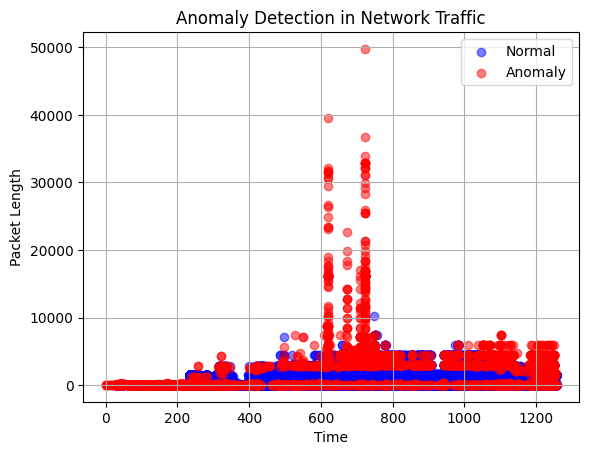

In [23]:
normal = df_encoded['anomaly'] == 1
anomaly = df_encoded['anomaly'] == -1

plt.scatter(df['Time'][normal], df['Length'][normal], c='blue', label='Normal', alpha=0.5)
plt.scatter(df['Time'][anomaly], df['Length'][anomaly], c='red', label='Anomaly', alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Packet Length")
plt.title("Anomaly Detection in Network Traffic")
plt.grid(True)
plt.ylim()
plt.legend()
plt.show()


In [28]:
# Filter paket anomali
anomalies = df_encoded[df_encoded['anomaly'] == -1].copy()

# balikin kolom Protocol ke nama asli
anomalies['Protocol'] = le.inverse_transform(anomalies['Protocol'])

# hitung top 5 protocol terbanyak muncul di anomali
protocol_counts = anomalies['Protocol'].value_counts().reset_index()
protocol_counts.columns = ['Protocol', 'Count']  # rename kolom biar jelas

from tabulate import tabulate
print(tabulate(protocol_counts.head(5), headers='keys', tablefmt='fancy_grid'))

# Top 5 Source IPs di anomali
print(tabulate(anomalies['Source'].value_counts().reset_index().head(5),
               headers=['Source IP', 'Count'], tablefmt='fancy_grid'))

# Top 5 Destination IPs di anomali
print(tabulate(anomalies['Destination'].value_counts().reset_index().head(5),
               headers=['Destination IP', 'Count'], tablefmt='fancy_grid'))


╒════╤════════════╤═════════╕
│    │ Protocol   │   Count │
╞════╪════════════╪═════════╡
│  0 │ TLSv1.3    │    1341 │
├────┼────────────┼─────────┤
│  1 │ ICMP       │     903 │
├────┼────────────┼─────────┤
│  2 │ DNS        │     746 │
├────┼────────────┼─────────┤
│  3 │ ARP        │     447 │
├────┼────────────┼─────────┤
│  4 │ TCP        │     390 │
╘════╧════════════╧═════════╛
╒════╤═════════════════╤═════════╕
│    │ Source IP       │   Count │
╞════╪═════════════════╪═════════╡
│  0 │ 192.167.7.162   │    2642 │
├────┼─────────────────┼─────────┤
│  1 │ 192.167.7.157   │     330 │
├────┼─────────────────┼─────────┤
│  2 │ 10.27.3.2       │     203 │
├────┼─────────────────┼─────────┤
│  3 │ 192.167.7.164   │     195 │
├────┼─────────────────┼─────────┤
│  4 │ VMware_8a:5c:e6 │     106 │
╘════╧═════════════════╧═════════╛
╒════╤══════════════════╤═════════╕
│    │ Destination IP   │   Count │
╞════╪══════════════════╪═════════╡
│  0 │ 146.75.78.73     │    1217 │
├────┼─────

In [34]:
from ipywidgets import interact

@interact(protocol=anomalies['Protocol'].unique())
def show_ip(protocol):
    subset = anomalies[anomalies['Protocol'] == protocol]
    print(subset[['Source','Destination']].head(10))

interactive(children=(Dropdown(description='protocol', options=('NBNS', 'ARP', 'BROWSER', 'ICMPv6', 'DHCP', 'I…

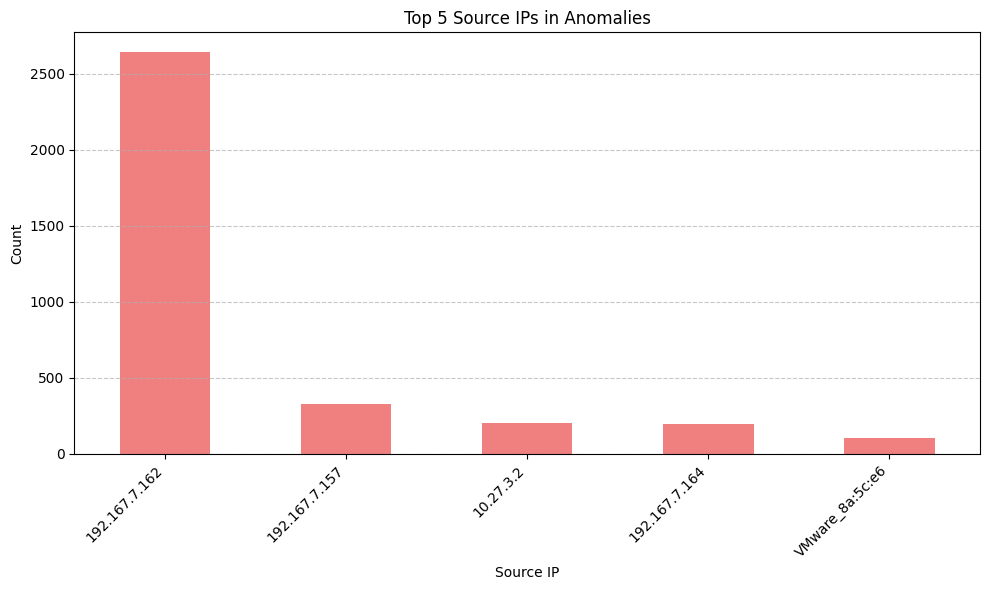

In [29]:
# Top 5 source IP anomalies
top_5_source_ips = anomalies['Source'].value_counts().head(5)

plt.figure(figsize=(10, 6))
top_5_source_ips.plot(kind='bar', color='lightcoral')
plt.title('Top 5 Source IPs in Anomalies')
plt.xlabel('Source IP')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Top 5 Destination IP anomalies
top_5_dest_ips = anomalies['Destination'].value_counts().head(5)

plt.figure(figsize=(10, 6))
top_5_dest_ips.plot(kind='bar', color='mediumseagreen')
plt.title('Top 5 Destination IPs in Anomalies')
plt.xlabel('Destination IP')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

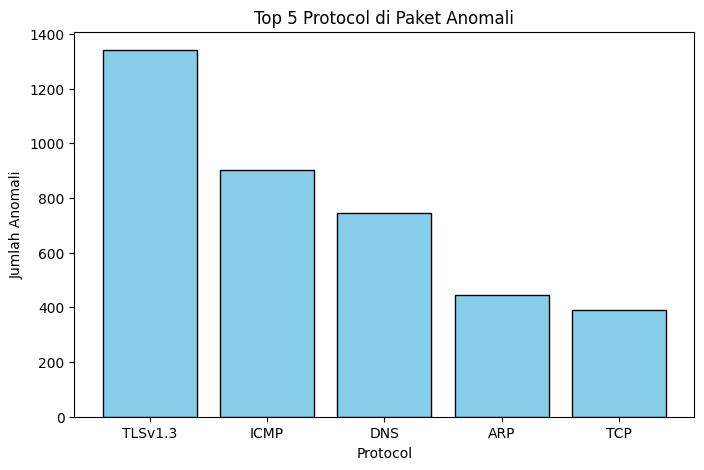

In [31]:
# Top 5 Protocol anomalies
top_5_protocol = protocol_counts.head(5)

plt.figure(figsize=(8,5))
plt.bar(top_5_protocol['Protocol'], top_5_protocol['Count'], color='skyblue', edgecolor='black')
plt.title("Top 5 Protocol di Paket Anomali")
plt.xlabel("Protocol")
plt.ylabel("Jumlah Anomali")
plt.show()